In [1]:
# Import standard libraries
from importlib import reload
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
from sklearn.cluster import AgglomerativeClustering
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import hicstraw
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import utils as lu

In [2]:
# Specify directories and relevant information
genome_dir = '/home/louiscam/projects/gpcr/data/genome_data/'
epigenome_dir = "/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/"
raw_hic_dir = '/home/louiscam/projects/gpcr/data/hic_data/IMR90/'
balanced_hic_dir = '/home/louiscam/projects/gpcr/save/processed_hic_data/'
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
arrowhead_dir = '/home/louiscam/projects/gpcr/save/processed_hic_domains/arrowhead/'

cell_type = 'IMR90'
quality = 'MAPQGE30'
intra_norm = 'KR'
inter_norm = 'GWKR'
resol = 250000
balanced_hic_dir = balanced_hic_dir+f'processed_hic_data_{cell_type}/'
balanced_hic_dir = balanced_hic_dir+f'final_BP{resol}_intra{intra_norm}_inter{inter_norm}/'

normalization = 'KR'
resolution = 5000
chrom_list = np.arange(1, 22+1, 1)

In [3]:
# List of colors
colors = np.array(["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "gray", "black", "white",
          "cyan", "magenta", "teal", "navy", "gold", "silver", "violet", "lime", "olive", "maroon", "indigo"])
colors_dict = {chrom: colors[chrom-1] for chrom in chrom_list}

# Load data

## Hi-C

In [4]:
# Load Hi-C
hic = hicstraw.HiCFile(raw_hic_dir+'GSE63525_IMR90_combined_30.hic')
print(f'Genome ID = {hic.getGenomeID()}')
print(f'Resolutions = {hic.getResolutions()}')

Genome ID = hg19
Resolutions = [2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000]


## Epigenomic marks

In [5]:
# List of all available epigenomic marks
epigenomic_marks_df = pd.read_csv(epigenome_dir+'filenames_belyaeva.csv', sep=',', header=0)

## Loci

In [6]:
# Load all loci
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci_from_clustering = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci_from_clustering = pickle.load(f)
all_loci = all_active_loci_from_clustering+all_inactive_loci_from_clustering
all_loci = sorted(all_loci)

In [7]:
# Divide genome into portions corresponding to loci
df_sizes = lu.get_chrom_sizes(genome_dir, resol)
df_chrom_list = []
for chrom in chrom_list:
    # Get chromosome size
    chrom_size = int(df_sizes.loc[df_sizes['chr']==str(chrom)]['size'])
    # Divide the chromosome into segments of HIC_RESOLN length
    stop_pos = np.arange(resol, chrom_size + resol, resol, dtype = 'int')
    df_chrom = pd.DataFrame()
    df_chrom['chrom'] = ['chr' + str(chrom)]*len(stop_pos)
    df_chrom['start'] = stop_pos - resol
    df_chrom['stop'] = stop_pos
    df_chrom_list.append(df_chrom)
all_loci_pos = pd.concat(df_chrom_list, axis=0)
all_loci_pos.loc[:, 'name'] = all_loci_pos.apply(
    lambda row: f"{row['chrom']}_loc_{row['start']}", axis=1
)

# Convert all_loci_pos to bed file
bed_all_loci = pybedtools.BedTool.from_dataframe(all_loci_pos)
bed_all_loci = bed_all_loci.sort()

In [8]:
# Load blacklisted loci
with open(balanced_hic_dir+f'blacklist_IMR90_{inter_norm}.pickle', 'rb') as f:
    blacklist_list = pickle.load(f)

## Gene locations

In [9]:
# Gene location in hg19
gene_locations_filename = genome_dir+'chrom_hg19.loc_canonical'
gene_id_filename = genome_dir+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
df_loc.head()

,transcript,geneSymbol,#chrom,chromStart,chromEnd,clusterId,protein
30786,uc021ree.1,7SK,chr12,114942680,114942992,7071,uc021ree.1
15095,uc002qsd.4,A1BG,chr19,58858171,58864865,15924,uc002qsd.4
14204,uc002qsg.3,A1BG-AS1,chr19,58863335,58866549,15925,uc002qsg.3
3436,uc001jjj.3,A1CF,chr10,52559168,52645435,3274,uc001jjj.3
6250,uc001qvk.1,A2M,chr12,9220303,9268558,6062,uc001qvk.1


In [10]:
# Create BED object for gene locations
allgenes_df = df_loc[['#chrom', 'chromStart', 'chromEnd', 'geneSymbol']].copy()
allgenes_df.columns = ['chrom', 'start', 'end', 'name']
allgenes_df = allgenes_df.reset_index(drop=True)
allgenes_bed = pybedtools.BedTool.from_dataframe(allgenes_df)
allgenes_bed = allgenes_bed.sort()

## Adhesome genes

In [11]:
# Adhesome genes
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes = pickle.load(f)

In [12]:
# Create BED object for adhesome gene locations
adhesome_df = df_loc[df_loc['geneSymbol'].isin(active_adhesome_genes)]
adhesome_df = adhesome_df[['#chrom', 'chromStart', 'chromEnd', 'geneSymbol']]
adhesome_df.columns = ['chrom', 'start', 'end', 'name']
adhesome_df = adhesome_df.reset_index(drop=True)
adhesome_bed = pybedtools.BedTool.from_dataframe(adhesome_df)
adhesome_bed = adhesome_bed.sort()

## TADs

In [13]:
# Load TAD data
fname = arrowhead_dir+f'{normalization}/{resolution}/processed_tads_list.csv'
processed_tads_df = pd.read_csv(fname, header=0, index_col=0)
print(f"Total number of TADs = {len(processed_tads_df)}")
processed_tads_df.head()

Total number of TADs = 4443


,chromo,start,end,length
0,1,1060001,1165000,105000
1,1,1325001,1440000,115000
2,1,1880001,1980000,100000
3,1,2120001,2320000,200000
4,1,2345001,2460000,115000


In [14]:
# Create BED object
processed_tads_df.loc[:, 'name'] =  processed_tads_df.apply(
    lambda row: f"tad_chr{row['chromo']}_{row['start']}_{row['end']}", axis=1
)
processed_tads_df.loc[:, 'chromo'] = 'chr'+processed_tads_df['chromo'].astype(str)
processed_tads_df = processed_tads_df[['chromo', 'start', 'end', 'name']]
processed_tads_df.columns = ['chrom', 'start', 'end', 'name']
processed_tads_bed = pybedtools.BedTool.from_dataframe(processed_tads_df)
processed_tads_bed = processed_tads_bed.sort()

# Identify adhesome TADs

## 250kb loci corresponding to TADs

In [15]:
# Map 250kb loci to TADs
out_loci = pybedtools.bedtool.BedTool.map(
    processed_tads_bed, 
    bed_all_loci, 
    c=[4], 
    o='distinct',
    f=0.1,
)
out_loci = out_loci.to_dataframe()

In [16]:
# Postprocess results
out_loci.columns = ['chrom', 'start', 'end', 'name', 'loci']
out_loci.loc[:, 'chrom'] = out_loci['chrom'].str.strip('chr').astype(int)
out_loci['loci'] = out_loci['loci'].str.replace('.', '')
out_loci['loci'] = out_loci['loci'].str.split(',')
out_loci.loc[:, 'loci'] = out_loci.apply(
    lambda row: row['loci'] if (row['loci'][0]!='') else list(), axis=1
)
out_loci.loc[:, 'n_loci'] = out_loci.apply(
    lambda row: len(row['loci']), axis=1
)

## Genes located in TADs

In [17]:
# Map genes to their TADs
out_all = pybedtools.bedtool.BedTool.map(
    processed_tads_bed, 
    allgenes_bed, 
    c=[4], 
    o='distinct',
    F=0.25 # Minimum overlap required as a fraction of B.
)
out_all = out_all.to_dataframe()

In [18]:
# Postprocess results
out_all.columns = ['chrom', 'start', 'end', 'name', 'genes']
out_all.loc[:, 'chrom'] = out_all['chrom'].str.strip('chr').astype(int)
out_all['genes'] = out_all['genes'].str.replace('.', '')
out_all['genes'] = out_all['genes'].str.split(',')
out_all.loc[:, 'genes'] = out_all.apply(
    lambda row: row['genes'] if (row['genes'][0]!='') else list(), axis=1
)
out_all.loc[:, 'n_genes'] = out_all.apply(
    lambda row: len(row['genes']), axis=1
)

## Adhesome genes located in TADs

In [19]:
# Map genes to their TADs
out_adhesome = pybedtools.bedtool.BedTool.map(
    processed_tads_bed, 
    adhesome_bed, 
    c=[4], 
    o='distinct',
    F=0.25 # Minimum overlap required as a fraction of B.
)
out_adhesome = out_adhesome.to_dataframe()

In [20]:
# Postprocess results
out_adhesome.columns = ['chrom', 'start', 'end', 'name', 'adhesome_genes']
out_adhesome.loc[:, 'chrom'] = out_adhesome['chrom'].str.strip('chr').astype(int)
out_adhesome['adhesome_genes'] = out_adhesome['adhesome_genes'].str.replace('.', '')
out_adhesome['adhesome_genes'] = out_adhesome['adhesome_genes'].str.split(',')
out_adhesome.loc[:, 'adhesome_genes'] = out_adhesome.apply(
    lambda row: row['adhesome_genes'] if (row['adhesome_genes'][0]!='') else list(), axis=1
)
out_adhesome.loc[:, 'n_adhesome_genes'] = out_adhesome.apply(
    lambda row: len(row['adhesome_genes']), axis=1
)
# out_adhesome = out_adhesome[out_adhesome['n_adhesome_genes']>0]
out_adhesome.head()

,chrom,start,end,name,adhesome_genes,n_adhesome_genes
0,1,1060001,1165000,tad_chr1_1060001_1165000,[],0
1,1,1325001,1440000,tad_chr1_1325001_1440000,[],0
2,1,1880001,1980000,tad_chr1_1880001_1980000,[],0
3,1,2120001,2320000,tad_chr1_2120001_2320000,[],0
4,1,2345001,2460000,tad_chr1_2345001_2460000,[],0


Number of adhesome genes in TADs = 132
Number of adhesome TADs = 134


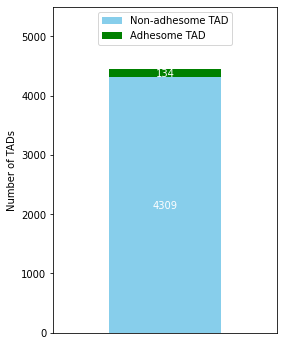

In [21]:
# Descriptive statistics
adhesome_genes_in_tads = np.unique(sorted(itertools.chain.from_iterable(out_adhesome['adhesome_genes'].values)))

print(f"Number of adhesome genes in TADs = {len(adhesome_genes_in_tads)}")
print(f"Number of adhesome TADs = {out_adhesome[out_adhesome['n_adhesome_genes']>0].shape[0]}")

# Plot number of adhesome and non-adhesome TADs
df = (out_adhesome[['n_adhesome_genes']]>0).groupby('n_adhesome_genes').size().to_frame('')
df.index.name = None
df.index = ['Non-adhesome TAD', 'Adhesome TAD']
df = df.T

fig, ax = plt.subplots()
df.plot(
    kind='bar', 
    stacked=True, 
    color=['skyblue', 'green'],
    figsize=(4, 6),
    ax=ax
)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2, y + height/2, f'{int(height)}', ha='center', va='center', color='w')

plt.xticks(ticks=[])
plt.ylabel('Number of TADs')

plt.ylim(0, 5500)
plt.legend(loc='upper center')

plt.show()

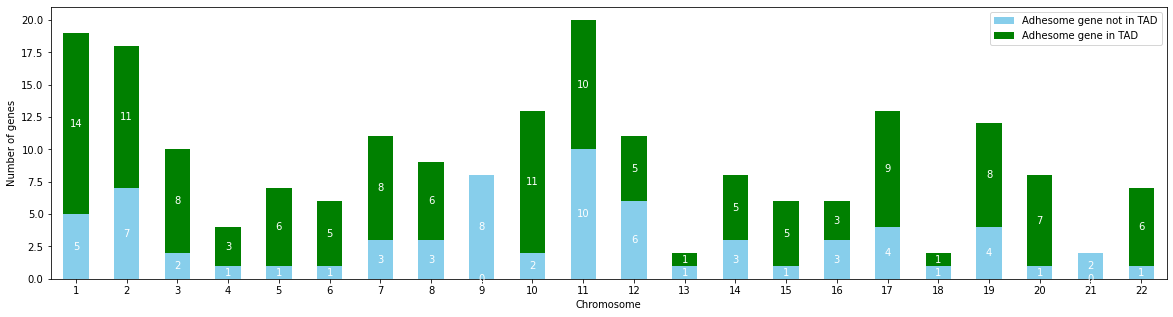

In [22]:
# Compare adhesome genes in TADs and total number of adhesome genes
total_adhesome_df = adhesome_df[['chrom', 'name']].copy()
total_adhesome_df.loc[:, 'chrom'] = total_adhesome_df['chrom'].str.strip('chr').astype(int)
total_adhesome_df = total_adhesome_df.sort_values(['chrom', 'name'])
total_adhesome_df.loc[:, 'in_tad'] = total_adhesome_df['name'].isin(adhesome_genes_in_tads).astype(int)
total_adhesome_df = total_adhesome_df.groupby(['chrom', 'in_tad'])['in_tad'].count().to_frame('Number of genes')
total_adhesome_df = total_adhesome_df.unstack()
total_adhesome_df = total_adhesome_df.droplevel(0, axis=1)
total_adhesome_df.columns = ['Adhesome gene not in TAD', 'Adhesome gene in TAD']

fig, ax = plt.subplots()

total_adhesome_df.plot(
    kind='bar', 
    stacked=True, 
    color=['skyblue', 'green'],
    figsize=(20, 5),
    ax=ax
)

plt.xlabel('Chromosome')
plt.ylabel('Number of genes')
plt.xticks(rotation=0)

# Add value annotations to each bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2, y + height/2, f'{int(height)}', ha='center', va='center', color='w')

plt.show()

## TAD transcription level (and other cistromic)

In [23]:
# Load processed transcriptomic and epigenomic information for all TADs
out_cistromic = pd.read_csv(
    saving_dir+f'features_matrix_all_tads_norm{normalization}_resolution{resolution}.csv', 
    header=0, 
    index_col=0
)
out_cistromic = out_cistromic.reset_index()
out_cistromic.loc[:, 'chrom'] = out_cistromic['name'].str.split('_', expand=True)[1].str.strip('chr').astype(int)
out_cistromic.loc[:, 'start'] = out_cistromic['name'].str.split('_', expand=True)[2].astype(int)
out_cistromic.loc[:, 'end'] = out_cistromic['name'].str.split('_', expand=True)[3].astype(int)
out_cistromic.head()

,name,rnaseq,CEBPB,CHD1,CTCF,DNase-seq,EP300,H2AK5ac,H2AK9ac,H2AY,...,RAD21,RB1,RBL2,RCOR1,RELA,RFX5,YAP1,chrom,start,end
0,tad_chr10_100070001_100185000,0.188017,0.605833,-0.788639,-2.491917,-0.976879,0.283054,-0.848227,-0.947800,0.774458,...,0.673459,-0.266019,-0.458829,-1.134967,-0.241231,2.264041,0.337494,10,100070001,100185000
1,tad_chr10_100500001_101015000,-0.122762,-1.310068,0.117755,-1.003458,-0.221317,0.285996,0.238734,-0.873028,-1.485505,...,-0.856970,-0.266019,-0.458829,-0.352054,-0.241231,-0.455935,0.463884,10,100500001,101015000
2,tad_chr10_101215001_101365000,0.211522,0.228658,-0.788639,-2.491917,-1.233268,0.122714,0.272739,-1.124464,0.559648,...,-2.241534,-0.266019,-0.458829,-1.134967,-0.241231,-0.455935,-1.546434,10,101215001,101365000
3,tad_chr10_101380001_101480000,0.982020,0.808589,-0.788639,0.815929,0.539065,1.151865,0.734931,0.137098,-1.485505,...,0.835421,-0.266019,-0.458829,0.604923,-0.241231,-0.455935,0.997379,10,101380001,101480000
4,tad_chr10_101495001_101600000,-0.059686,0.737498,-0.788639,0.754879,-2.843286,-1.589815,-2.382673,-2.657039,-1.485505,...,-2.241534,-0.266019,-0.458829,-1.134967,-0.241231,-0.455935,-1.546434,10,101495001,101600000


## Combine information

In [24]:
# Concatenate results
enriched_tads_df = pd.concat(
    [
        out_loci.set_index(['chrom', 'start', 'end', 'name']), 
        out_all.set_index(['chrom', 'start', 'end', 'name']), 
        out_adhesome.set_index(['chrom', 'start', 'end', 'name']),
        out_cistromic.set_index(['chrom', 'start', 'end', 'name'])
    ], 
    axis=1
)
enriched_tads_df = enriched_tads_df.reset_index()
enriched_tads_df = enriched_tads_df.set_index('name')
enriched_tads_df = enriched_tads_df.sort_values('chrom')
enriched_tads_df.insert(
    loc=3, 
    column='length', 
    value=enriched_tads_df['end']-enriched_tads_df['start']+1
)

enriched_adhesome_tads_df = enriched_tads_df[enriched_tads_df['n_adhesome_genes']>0]
enriched_tads_df.head()

,chrom,start,end,length,loci,n_loci,genes,n_genes,adhesome_genes,n_adhesome_genes,...,MECP2,MXI1,POLR2A,RAD21,RB1,RBL2,RCOR1,RELA,RFX5,YAP1
name,,,,,,,,,,,,,,,,,,,,,
tad_chr1_1060001_1165000,1,1060001,1165000,105000,[chr1_loc_1000000],1,"[AK128833, JA715134, JA715143, LOC254099, MIR2...",11,[],0,...,1.807906,0.406501,1.114935,-2.241534,-0.266019,-0.458829,-1.134967,-0.241231,-0.455935,-1.546434
tad_chr1_165375001_165555000,1,165375001,165555000,180000,"[chr1_loc_165250000, chr1_loc_165500000]",2,"[LOC400794, LRRC52, RXRG]",3,[],0,...,-0.732692,-1.313034,-1.148367,-2.241534,-0.266019,-0.458829,0.229368,3.472344,-0.455935,-1.546434
tad_chr1_164555001_164760000,1,164555001,164760000,205000,[chr1_loc_164500000],1,"[AX748175, LOC100505795, PBX1]",3,[],0,...,-0.732692,-0.019005,-1.148367,0.031281,-0.266019,-0.458829,1.339363,-0.241231,-0.455935,0.981718
tad_chr1_163150001_163280000,1,163150001,163280000,130000,"[chr1_loc_163000000, chr1_loc_163250000]",2,[RGS5],1,[],0,...,-0.732692,-1.313034,-1.148367,-2.241534,-0.266019,-0.458829,-1.134967,-0.241231,-0.455935,0.511774
tad_chr1_163050001_163140000,1,163050001,163140000,90000,[chr1_loc_163000000],1,[RGS5],1,[],0,...,-0.732692,-1.313034,-1.148367,-2.241534,-0.266019,-0.458829,0.674745,-0.241231,-0.455935,0.488392


Total number of loci = 4443
Number of loci in cluster 0 = 2584
Number of loci in cluster 1 = 1859


<Figure size 432x288 with 0 Axes>

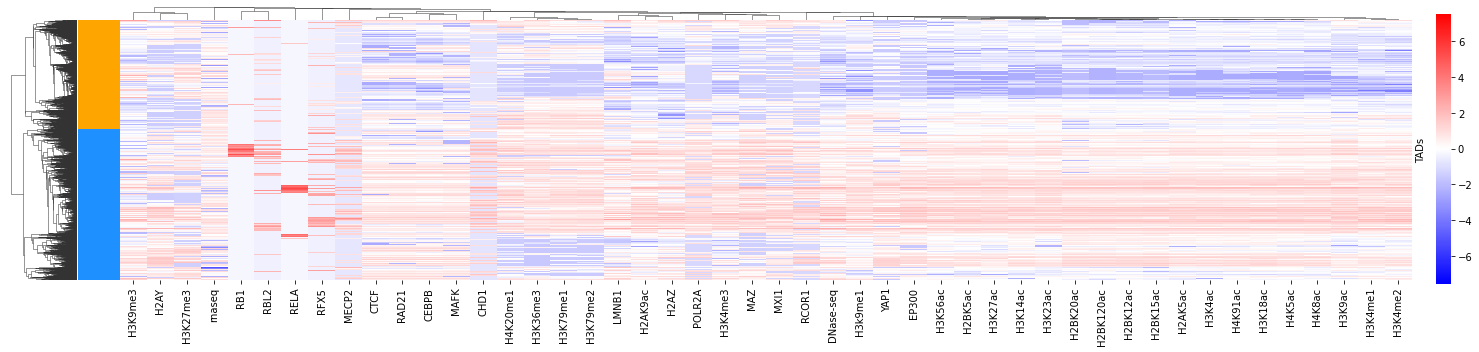

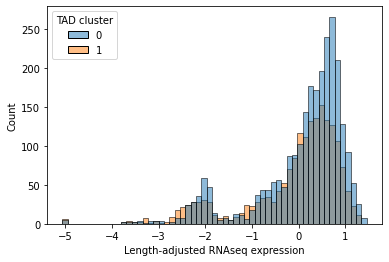

In [25]:
# Visualize TADs
tads_cistromic_df = enriched_tads_df.iloc[:, 10:].copy()
tads_cistromic_df.index.name = 'TADs'

# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average').fit(tads_cistromic_df)
print('Total number of loci = '+str(len(clustering.labels_)))
print('Number of loci in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of loci in cluster 1 = '+str(np.sum(clustering.labels_==1)))

# Plot clustered heatmap
color_clusters = np.array(['dodgerblue', 'orange'])
plt.figure()
sns.clustermap(
    data=tads_cistromic_df.astype(float),
    metric='cosine',
    method='average',
    row_colors=color_clusters[clustering.labels_],
    cmap='bwr', 
    vmin=-np.abs(tads_cistromic_df).max().max(), 
    vmax=np.abs(tads_cistromic_df).max().max(),
    dendrogram_ratio=0.05,
    xticklabels=True,
    yticklabels=False,
    cbar_pos=(1, 0.2, 0.01, 0.75),
    figsize=(20,5)
)
plt.show()

# Plot distribution of RNAseq in both clusters
tads_cistromic_df.loc[:, 'TAD cluster'] = clustering.labels_
plt.figure()
sns.histplot(data=tads_cistromic_df, x='rnaseq', hue='TAD cluster')
plt.xlabel('Length-adjusted RNAseq expression')
plt.ylabel('Count')
plt.show()

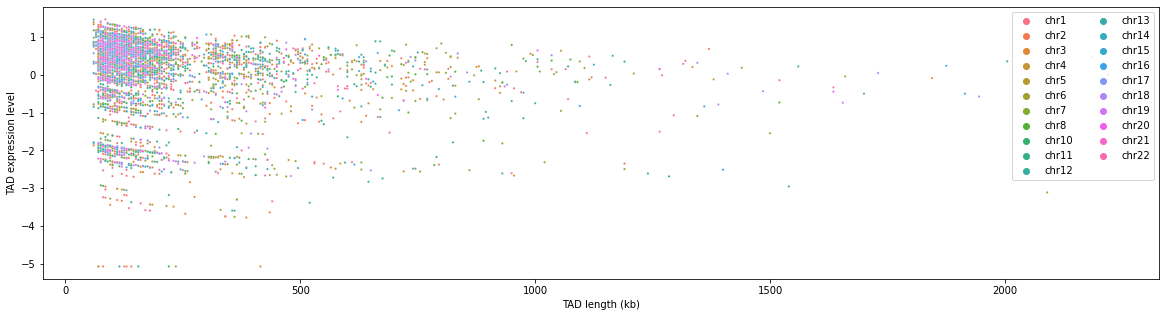

In [26]:
# Segment TADs by chromosome, size, transcription
tads_segmentation_df = enriched_tads_df[['chrom', 'length', 'rnaseq']].copy()
tads_segmentation_df.loc[:, 'length'] = (tads_segmentation_df['length']/1000)
tads_segmentation_df.loc[:, 'chrom'] = 'chr'+tads_segmentation_df['chrom'].astype(str)

plt.figure(figsize=(20, 5))
sns.scatterplot(
    data=tads_segmentation_df, 
    x='length', 
    y='rnaseq', 
    hue='chrom',
    s=5,
)
plt.xlabel('TAD length (kb)')
plt.ylabel('TAD expression level')
plt.legend(loc='upper right', ncol=2)
plt.show()

## Interchromosomal contacts

In [27]:
# Function to retrieve Hi-C contacts between 2 TADs
def retrieve_tad_contact(tad_idx1, tad_idx2, enriched_tads_df, balanced_hic_dir, blacklist_list):
    
    # TAD1
    chrom1 = enriched_tads_df.loc[tad_idx1, 'chrom']
    start1 = enriched_tads_df.loc[tad_idx1, 'start']
    end1 = enriched_tads_df.loc[tad_idx1, 'end']
    loci1 = enriched_tads_df.loc[tad_idx1, 'loci']
    loci1 = list(set(loci1)-set(blacklist_list))

    # TAD2
    chrom2 = enriched_tads_df.loc[tad_idx2, 'chrom']
    start2 = enriched_tads_df.loc[tad_idx2, 'start']
    end2 = enriched_tads_df.loc[tad_idx2, 'end']
    loci2 = enriched_tads_df.loc[tad_idx2, 'loci']
    loci2 = list(set(loci2)-set(blacklist_list))
    
    # Access Hi-C
    processed_hic_filename = 'hic_'+'chr'+str(chrom1)+'_'+'chr'+str(chrom2)+'_norm1_filter3'+'.pkl'
    with open(balanced_hic_dir+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)
        
    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    contacts_ls = []
    locus_id_pairs = itertools.product(loci1, loci2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[2])
        locus2 = int(locus2_id.split('_')[2])
        contacts_ls.append(hic_chpair_df.loc[locus1, locus2])
    avg_contact = np.average(contacts_ls)
    return(avg_contact)

In [28]:
# Build matrix of Hi-C contacts between adhesome TADs
adhesome_tads_contacts = pd.DataFrame(
    0, 
    index=enriched_adhesome_tads_df.index, 
    columns=enriched_adhesome_tads_df.index
)
for idx1, idx2 in tqdm(list(itertools.combinations(enriched_adhesome_tads_df.index, 2))):
    adhesome_tads_contacts.loc[idx1, idx2] = retrieve_tad_contact(
        idx1, 
        idx2, 
        enriched_adhesome_tads_df, 
        balanced_hic_dir,
        blacklist_list
    )
adhesome_tads_contacts = adhesome_tads_contacts+adhesome_tads_contacts.T
adhesome_tads_contacts.index.name = 'Adhesome TADs'
adhesome_tads_contacts.columns.name = 'Adhesome TADs'

<Figure size 432x288 with 0 Axes>

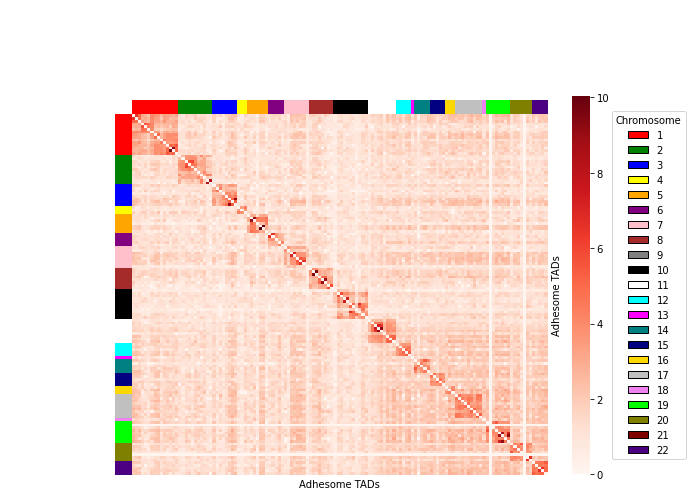

In [29]:
# Plot adhesome TADs Hi-C contacts
plt.figure()
cluster_map = sns.clustermap(
    data=adhesome_tads_contacts,
    cmap='Reds',
    vmin=0,
    vmax=adhesome_tads_contacts.max().max(),
    cbar_pos=(1, 0.05, 0.03, 0.75),
    row_cluster=False,
    col_cluster=False,
    row_colors=[colors_dict[c] for c in [int(tad.split('_')[1][3:]) for tad in adhesome_tads_contacts.index]],
    col_colors=[colors_dict[c] for c in [int(tad.split('_')[1][3:]) for tad in adhesome_tads_contacts.index]],
    xticklabels=False,
    yticklabels=False,
    figsize=(8, 7)
)

# Create legend handles and labels
legend_elements = [Patch(facecolor=colors_dict[c], edgecolor='k') for c in chrom_list]

# Add legend
plt.legend(
    handles=legend_elements, 
    labels=map(str, chrom_list), 
    title='Chromosome', 
    loc='center left', 
    bbox_to_anchor=(2, 0.5)
)

# Show the plot
plt.show()


# Create TADs background distribution

## Segment TAD by chromosome, size, transcription level

In [57]:
# Select relevant parameters
tads_segmentation_df = enriched_tads_df[['chrom', 'length', 'rnaseq', 'n_adhesome_genes']].copy()
tads_segmentation_df.loc[:, 'chrom'] = 'chr'+tads_segmentation_df['chrom'].astype(str)
tads_segmentation_df.head()

,chrom,length,rnaseq,n_adhesome_genes
name,,,,
tad_chr1_1060001_1165000,chr1,105000,0.738828,0
tad_chr1_165375001_165555000,chr1,180000,-3.590231,0
tad_chr1_164555001_164760000,chr1,205000,0.174066,0
tad_chr1_163150001_163280000,chr1,130000,-0.220223,0
tad_chr1_163050001_163140000,chr1,90000,0.053899,0


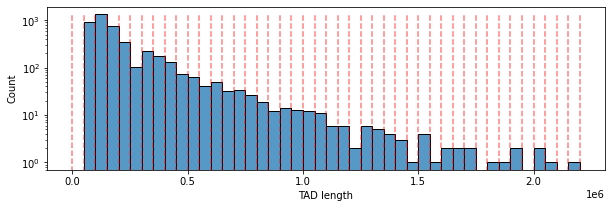

In [58]:
# Distribution of TAD lengths
delta_length = 50000
plt.figure(figsize=(10,3))
h = sns.histplot(
    data=tads_segmentation_df,
    x='length',
    bins=np.arange(0, tads_segmentation_df['length'].max()+1, delta_length)
)
for b in np.arange(0, tads_segmentation_df['length'].max()+1, delta_length):
    plt.vlines(
        x=b, 
        ymin=0, 
        ymax=max([p.get_height() for p in h.patches]), 
        color='red', 
        linestyle='dashed', 
        alpha=0.5
    )
plt.yscale('log')
plt.xlabel('TAD length')
plt.ylabel('Count')
plt.show()

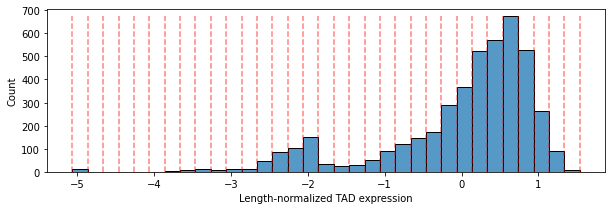

In [59]:
# Distribution of TAD expression
delta_rnaseq = 0.2
plt.figure(figsize=(10,3))
h = sns.histplot(
    data=tads_segmentation_df,
    x='rnaseq',
    bins=np.arange(tads_segmentation_df['rnaseq'].min(), tads_segmentation_df['rnaseq'].max()+0.1, delta_rnaseq)
)
for b in np.arange(tads_segmentation_df['rnaseq'].min(), tads_segmentation_df['rnaseq'].max()+0.1, delta_rnaseq):
    plt.vlines(
        x=b, 
        ymin=0, 
        ymax=max([p.get_height() for p in h.patches]), 
        color='red', 
        linestyle='dashed', 
        alpha=0.5
    )
# plt.yscale('log')
plt.xlabel('Length-normalized TAD expression')
plt.ylabel('Count')
plt.show()

In [60]:
# Segment
tads_segmentation_df.loc[:, 'length_bucket'] = (tads_segmentation_df['length']//delta_length).astype(int)
tads_segmentation_df.loc[:, 'rnaseq_bucket'] = (tads_segmentation_df['rnaseq']//delta_rnaseq).astype(int)
tads_segmentation_df.head()

,chrom,length,rnaseq,n_adhesome_genes,length_bucket,rnaseq_bucket
name,,,,,,
tad_chr1_1060001_1165000,chr1,105000,0.738828,0,2,3
tad_chr1_165375001_165555000,chr1,180000,-3.590231,0,3,-18
tad_chr1_164555001_164760000,chr1,205000,0.174066,0,4,0
tad_chr1_163150001_163280000,chr1,130000,-0.220223,0,2,-2
tad_chr1_163050001_163140000,chr1,90000,0.053899,0,1,0


## Comparison of adhesome TAD Hi-C with random TAD HiC

In [61]:
# Function to sample a random sample of TADs controlling for chromosome, size, and expression
def sample_tads(tads_segmentation_df, enriched_adhesome_tads_df, delta_length, delta_rnaseq):
    
    adhesome_tads_list = enriched_adhesome_tads_df.index.values
    
    random_tad_list = []
    for tad in enriched_adhesome_tads_df.index:
        # Characteristics of the chosen TAD
        tad_chrom = enriched_adhesome_tads_df.loc[tad, 'chrom']
        tad_length_bucket = int(enriched_adhesome_tads_df.loc[tad, 'length']/delta_length)
        tad_rnaseq_bucket = int(enriched_adhesome_tads_df.loc[tad, 'rnaseq']/delta_rnaseq)

        # Identify TAD pool to choose from
        tad_pool = tads_segmentation_df[
            (tads_segmentation_df['chrom']=='chr'+str(tad_chrom)) &
            (tads_segmentation_df['length_bucket']==tad_length_bucket) &
            (tads_segmentation_df['rnaseq_bucket']==tad_rnaseq_bucket) &
            (~tads_segmentation_df.index.isin(adhesome_tads_list))
        ].index.values
        # If the TAD pool is empty, widen the buckets
        slack = 1
        while (tad_pool.shape[0]==0):
            extended_length_bucket = np.arange(tad_length_bucket-slack, tad_length_bucket+slack, slack)
            extended_rnaseq_bucket = np.arange(tad_rnaseq_bucket-slack, tad_rnaseq_bucket+slack, slack)
            tad_pool = tads_segmentation_df[
                (tads_segmentation_df['chrom']=='chr'+str(tad_chrom)) &
                (tads_segmentation_df['length_bucket'].isin(extended_length_bucket)) &
                (tads_segmentation_df['rnaseq_bucket'].isin(extended_rnaseq_bucket))
            ].index.values
            slack = slack+1

        # Randomly sample TAD and add it to the list
        random_tad = np.random.choice(tad_pool)
        random_tad_list.append(random_tad)
    return(random_tad_list)

In [62]:
# Sample random TAD list
random_tads = sample_tads(tads_segmentation_df, enriched_adhesome_tads_df, delta_length, delta_rnaseq)

# Build matrix of Hi-C contacts between random TADs
tads_contacts = pd.DataFrame(
    0, 
    index=random_tads, 
    columns=random_tads
)
for idx1, idx2 in tqdm(list(itertools.combinations(random_tads, 2))):
    tads_contacts.loc[idx1, idx2] = retrieve_tad_contact(
        idx1, 
        idx2, 
        enriched_tads_df, 
        balanced_hic_dir,
        blacklist_list
    )
tads_contacts = tads_contacts+tads_contacts.T
tads_contacts.index.name = 'Random TADs'
tads_contacts.columns.name = 'Random TADs'

<Figure size 432x288 with 0 Axes>

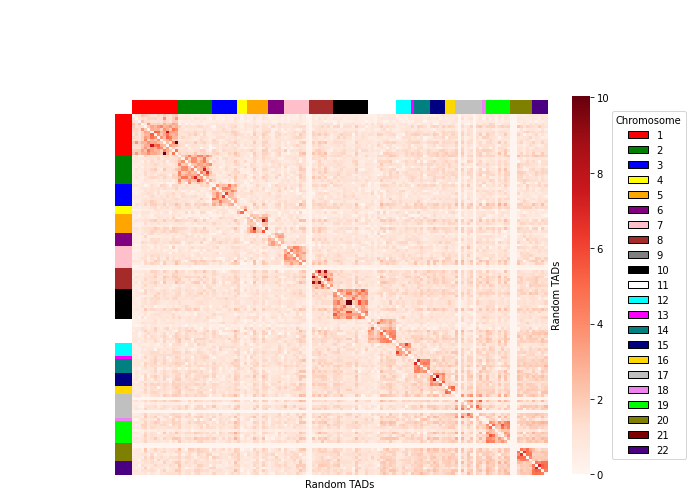

In [63]:
# Plot random TADs Hi-C contacts
plt.figure()
cluster_map = sns.clustermap(
    data=tads_contacts,
    cmap='Reds',
    vmin=0,
    vmax=adhesome_tads_contacts.max().max(),
    cbar_pos=(1, 0.05, 0.03, 0.75),
    row_cluster=False,
    col_cluster=False,
    row_colors=[colors_dict[c] for c in [int(tad.split('_')[1][3:]) for tad in tads_contacts.index]],
    col_colors=[colors_dict[c] for c in [int(tad.split('_')[1][3:]) for tad in tads_contacts.index]],
    xticklabels=False,
    yticklabels=False,
    figsize=(8, 7)
)

# Create legend handles and labels
legend_elements = [Patch(facecolor=colors_dict[c], edgecolor='k') for c in chrom_list]

# Add legend
plt.legend(
    handles=legend_elements, 
    labels=map(str, chrom_list), 
    title='Chromosome', 
    loc='center left', 
    bbox_to_anchor=(2, 0.5)
)

# Show the plot
plt.show()


In [69]:
# Prepare random contact distributions

# Unstack contacts
tads_contacts_unstacked = tads_contacts.stack().to_frame('hic')
tads_contacts_unstacked.index.names = ['tad1', 'tad2']
tads_contacts_unstacked = tads_contacts_unstacked.reset_index()

# Add information on chromosomes of each pair of TADs
tads_contacts_unstacked.loc[:, 'tad1_chrom'] = tads_contacts_unstacked['tad1'].str.split('_', expand=True)[1]
tads_contacts_unstacked.loc[:, 'tad1_chrom'] = tads_contacts_unstacked['tad1_chrom'].str.strip('chr').astype(int)
tads_contacts_unstacked.loc[:, 'tad2_chrom'] = tads_contacts_unstacked['tad2'].str.split('_', expand=True)[1]
tads_contacts_unstacked.loc[:, 'tad2_chrom'] = tads_contacts_unstacked['tad2_chrom'].str.strip('chr').astype(int)

# Remove duplicate values
tads_contacts_unstacked = tads_contacts_unstacked[
    tads_contacts_unstacked['tad1_chrom'] <= tads_contacts_unstacked['tad2_chrom']
]

# Label interchromosomal and intrachromosomal interactions
tads_contacts_unstacked.loc[:, "Type"] = tads_contacts_unstacked.apply(
    lambda row: 'Random intrachromosomal' if (row['tad1_chrom']==row['tad2_chrom']) else 'Random interchromosomal', 
    axis=1
)

In [70]:
# Prepare adhesome contact distributions

# Unstack contacts
adhesome_tads_contacts_unstacked = adhesome_tads_contacts.stack().to_frame('hic')
adhesome_tads_contacts_unstacked.index.names = ['tad1', 'tad2']
adhesome_tads_contacts_unstacked = adhesome_tads_contacts_unstacked.reset_index()

# Add information on chromosomes of each pair of TADs
adhesome_tads_contacts_unstacked.loc[:, 'tad1_chrom'] = adhesome_tads_contacts_unstacked['tad1'].str.split('_', expand=True)[1]
adhesome_tads_contacts_unstacked.loc[:, 'tad1_chrom'] = adhesome_tads_contacts_unstacked['tad1_chrom'].str.strip('chr').astype(int)
adhesome_tads_contacts_unstacked.loc[:, 'tad2_chrom'] = adhesome_tads_contacts_unstacked['tad2'].str.split('_', expand=True)[1]
adhesome_tads_contacts_unstacked.loc[:, 'tad2_chrom'] = adhesome_tads_contacts_unstacked['tad2_chrom'].str.strip('chr').astype(int)

# Remove duplicate values
adhesome_tads_contacts_unstacked = adhesome_tads_contacts_unstacked[
    adhesome_tads_contacts_unstacked['tad1_chrom'] <= adhesome_tads_contacts_unstacked['tad2_chrom']
]

# Label interchromosomal and intrachromosomal interactions
adhesome_tads_contacts_unstacked.loc[:, "Type"] = adhesome_tads_contacts_unstacked.apply(
    lambda row: 'Adhesome intrachromosomal' if (row['tad1_chrom']==row['tad2_chrom']) else 'Adhesome interchromosomal', 
    axis=1
)

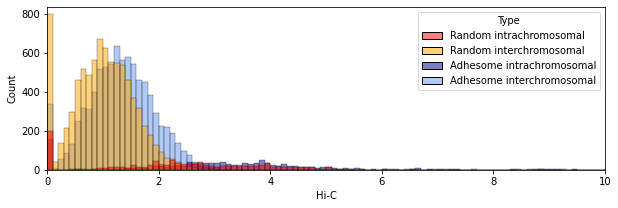

WRS p-value for interchromosomal contacts between TADs = 1.2588798329138544e-267
WRS p-value for interchromosomal contacts between TADs = 2.01349135929361e-15


In [71]:
# Compare contact distributions
combined_unstacked = pd.concat([tads_contacts_unstacked, adhesome_tads_contacts_unstacked], axis=0)
combined_unstacked = combined_unstacked.reset_index(drop=True)

plt.figure(figsize=(10, 3))
sns.histplot(
    data=combined_unstacked,
    x='hic',
    hue='Type',
    bins=np.arange(0, combined_unstacked['hic'].max(), 0.1),
    palette={
        'Adhesome interchromosomal': 'cornflowerblue', 
        'Random interchromosomal': 'orange',
        'Adhesome intrachromosomal': 'navy',
        'Random intrachromosomal': 'red'
    }
)
plt.xlim(0,10)
plt.xlabel('Hi-C')
plt.ylabel('Count')
plt.show()

# Wilcoxon Ranks Sum test for interchromosomal and intrachromosomal
stat, pval = ss.ranksums(
    x=combined_unstacked[combined_unstacked['Type']=='Adhesome interchromosomal']['hic'].values,
    y=combined_unstacked[combined_unstacked['Type']=='Random interchromosomal']['hic'].values,
    alternative='two-sided'
)
print(f"WRS p-value for interchromosomal contacts between TADs = {pval}")
stat, pval = ss.ranksums(
    x=combined_unstacked[combined_unstacked['Type']=='Adhesome intrachromosomal']['hic'].values,
    y=combined_unstacked[combined_unstacked['Type']=='Random intrachromosomal']['hic'].values,
    alternative='two-sided'
)
print(f"WRS p-value for interchromosomal contacts between TADs = {pval}")

## Compare adhesome to multiple random samples and report WRS p-values

In [42]:
# Perform comparison mutliple times
n_rep = 100
pval_intra_list = []
pval_inter_list = []
np.random.seed(13)

for i in range(n_rep):
    
    print(f"Processing repetition {i+1}")
    
    ##########################
    # Random TADs
    ##########################
    
    # Sample random TAD list
    random_tads = sample_tads(tads_segmentation_df, enriched_adhesome_tads_df, delta_length, delta_rnaseq)

    # Build matrix of Hi-C contacts between random TADs
    tads_contacts = pd.DataFrame(
        0, 
        index=random_tads, 
        columns=random_tads
    )
    for idx1, idx2 in tqdm(list(itertools.combinations(random_tads, 2))):
        tads_contacts.loc[idx1, idx2] = retrieve_tad_contact(
            idx1, 
            idx2, 
            enriched_tads_df, 
            balanced_hic_dir,
            blacklist_list
        )
    tads_contacts = tads_contacts+tads_contacts.T
    tads_contacts.index.name = 'Random TADs'
    tads_contacts.columns.name = 'Random TADs'
    
    ##########################
    # Prepare random contact distributions
    ##########################
    
    # Unstack contacts
    tads_contacts_unstacked = tads_contacts.stack().to_frame('hic')
    tads_contacts_unstacked.index.names = ['tad1', 'tad2']
    tads_contacts_unstacked = tads_contacts_unstacked.reset_index()

    # Add information on chromosomes of each pair of TADs
    tads_contacts_unstacked.loc[:, 'tad1_chrom'] = tads_contacts_unstacked['tad1'].str.split('_', expand=True)[1]
    tads_contacts_unstacked.loc[:, 'tad1_chrom'] = tads_contacts_unstacked['tad1_chrom'].str.strip('chr').astype(int)
    tads_contacts_unstacked.loc[:, 'tad2_chrom'] = tads_contacts_unstacked['tad2'].str.split('_', expand=True)[1]
    tads_contacts_unstacked.loc[:, 'tad2_chrom'] = tads_contacts_unstacked['tad2_chrom'].str.strip('chr').astype(int)

    # Remove duplicate values
    tads_contacts_unstacked = tads_contacts_unstacked[
        tads_contacts_unstacked['tad1_chrom'] <= tads_contacts_unstacked['tad2_chrom']
    ]

    # Label interchromosomal and intrachromosomal interactions
    tads_contacts_unstacked.loc[:, "type"] = tads_contacts_unstacked.apply(
        lambda row: 'Random intrachromosomal' if (row['tad1_chrom']==row['tad2_chrom']) else 'Random interchromosomal', 
        axis=1
    )
    
    ##########################
    # Compare contact distributions
    ##########################
    
    combined_unstacked = pd.concat([tads_contacts_unstacked, adhesome_tads_contacts_unstacked], axis=0)
    combined_unstacked = combined_unstacked.reset_index(drop=True)
    
    stat, pval = ss.ranksums(
        x=combined_unstacked[combined_unstacked['type']=='Adhesome interchromosomal']['hic'].values,
        y=combined_unstacked[combined_unstacked['type']=='Random interchromosomal']['hic'].values,
        alternative='two-sided'
    )
    pval_inter_list.append(pval)
    
    stat, pval = ss.ranksums(
        x=combined_unstacked[combined_unstacked['type']=='Adhesome intrachromosomal']['hic'].values,
        y=combined_unstacked[combined_unstacked['type']=='Random intrachromosomal']['hic'].values,
        alternative='two-sided'
    )
    pval_intra_list.append(pval)
    
pval_inter_list = np.array(pval_inter_list)
pval_intra_list = np.array(pval_intra_list)
pval_inter_list = [p if (p>0) else sys.float_info.min for p in pval_inter_list]
pval_intra_list = [p if (p>0) else sys.float_info.min for p in pval_intra_list]

with open(saving_dir+f'tad_pval_inter_list_norm{normalization}_resolution{resolution}.pkl', 'wb') as f:
    pickle.dump(pval_inter_list, f)
with open(saving_dir+f'tad_pval_intra_list_norm{normalization}_resolution{resolution}.pkl', 'wb') as f:
    pickle.dump(pval_intra_list, f)    


Processing repetition 1



Processing repetition 2



Processing repetition 3



Processing repetition 4



Processing repetition 5



Processing repetition 6



Processing repetition 7



Processing repetition 8



Processing repetition 9



Processing repetition 10



Processing repetition 11



Processing repetition 12



Processing repetition 13



Processing repetition 14



Processing repetition 15



Processing repetition 16



Processing repetition 17



Processing repetition 18



Processing repetition 19



Processing repetition 20



Processing repetition 21



Processing repetition 22



Processing repetition 23



Processing repetition 24



Processing repetition 25



Processing repetition 26



Processing repetition 27



Processing repetition 28



Processing repetition 29



Processing repetition 30



Processing repetition 31



Processing repetition 32



Processing repetition 33



Processing repetition 34



Processing repetition 35



Processing repetition 36



Processing repetition 37



Processing repetition 38



Processing repetition 39



Processing repetition 40



Processing repetition 41



Processing repetition 42



Processing repetition 43



Processing repetition 44



Processing repetition 45



Processing repetition 46



Processing repetition 47



Processing repetition 48



Processing repetition 49



Processing repetition 50



Processing repetition 51



Processing repetition 52



Processing repetition 53



Processing repetition 54



Processing repetition 55



Processing repetition 56



Processing repetition 57



Processing repetition 58



Processing repetition 59



Processing repetition 60



Processing repetition 61



Processing repetition 62



Processing repetition 63



Processing repetition 64



Processing repetition 65



Processing repetition 66



Processing repetition 67



Processing repetition 68



Processing repetition 69



Processing repetition 70



Processing repetition 71



Processing repetition 72



Processing repetition 73



Processing repetition 74



Processing repetition 75



Processing repetition 76



Processing repetition 77



Processing repetition 78



Processing repetition 79



Processing repetition 80



Processing repetition 81



Processing repetition 82



Processing repetition 83



Processing repetition 84



Processing repetition 85



Processing repetition 86



Processing repetition 87



Processing repetition 88



Processing repetition 89



Processing repetition 90



Processing repetition 91



Processing repetition 92



Processing repetition 93



Processing repetition 94



Processing repetition 95



Processing repetition 96



Processing repetition 97



Processing repetition 98



Processing repetition 99



Processing repetition 100


In [43]:
# Load pickled p-value lists
with open(saving_dir+f'tad_pval_inter_list_norm{normalization}_resolution{resolution}.pkl', 'rb') as f:
    pval_inter_list = pickle.load(f)
with open(saving_dir+f'tad_pval_intra_list_norm{normalization}_resolution{resolution}.pkl', 'rb') as f:
    pval_intra_list = pickle.load(f)    

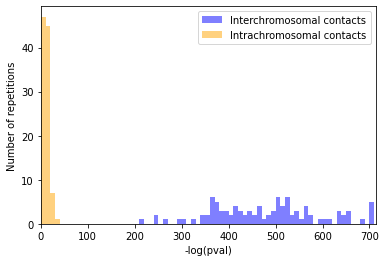

In [44]:
# Plot distribution of p-values
plt.figure()
plt.hist(
    x=-np.log(pval_inter_list),
    bins=np.arange(0, max(-np.log(pval_inter_list))+1, 10),
    color='blue',
    alpha=0.5,
    label='Interchromosomal contacts'
)
plt.hist(
    x=-np.log(pval_intra_list),
    bins=np.arange(0, max(-np.log(pval_inter_list))+1, 10),
    color='orange',
    alpha=0.5,
    label='Intrachromosomal contacts'
)
plt.xlabel('-log(pval)')
plt.ylabel('Number of repetitions')
plt.legend(loc='upper right')
plt.xlim(0, max(-np.log(pval_inter_list)))
plt.show()